In [4]:
import pandas as pd
import numpy as np

import re
from text_helper import word_splitter, sentence_count, stop_word_counter, punc_counter, emoji_checker

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder

from sklearn.compose import make_column_selector, ColumnTransformer

rs = 91923 

In [5]:
df = pd.read_csv('../data/data_final.csv')

In [3]:
X = df['response']
y = df['fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rs, stratify = y)

In [4]:
y_train.value_counts(normalize = True)

1    0.500062
0    0.499938
Name: fake, dtype: float64

Obviously, our baseline is 50% since half our data came from AI responses and half was real data that was gathered from reddit.

In [5]:
mnb_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('mnb', MultinomialNB())
    ]
)

bnb_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('bnb', BernoulliNB())
    ]
)

gnb_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('gnb', GaussianNB())
    ]
)

logr_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('logr', LogisticRegression(max_iter = 500, n_jobs = -1))
    ]
    )

rf_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('rf', RandomForestClassifier(random_state = rs, n_jobs = -1))
    ])

et_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('et', ExtraTreesClassifier(random_state = rs, n_jobs = -1))
    ]
)

linear_svc_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('lsvc', SVC(kernel = 'linear'))
    ]
)

rsvc_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('rsvc', SVC(kernel = 'rbf'))
    ]
)

adbc_pipe = Pipeline(
    [
        ('vect', CountVectorizer()),
        ('adbc', AdaBoostClassifier())
    ]
)

In [6]:
mnb_pipe.fit(X_train, y_train)
bnb_pipe.fit(X_train, y_train)
gnb_pipe.fit(X_train, y_train)
logr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
et_pipe.fit(X_train, y_train)
linear_svc_pipe.fit(X_train, y_train)
rsvc_pipe.fit(X_train, y_train)
adbc_pipe.fit(X_train, y_train)

print("MNB Train: {}\nMNB Test: {}\n----".format(mnb_pipe.score(X_train, y_train), mnb_pipe.score(X_test, y_test)))
print("BNB Train: {}\nBNB Test: {}\n----".format(bnb_pipe.score(X_train, y_train), bnb_pipe.score(X_test, y_test)))
print("GNB Train: {}\nGNB Test: {}\n----".format(gnb_pipe.score(X_train, y_train), gnb_pipe.score(X_test, y_test)))
print("LogReg Train: {}\nLogReg Test: {}\n----".format(logr_pipe.score(X_train, y_train), logr_pipe.score(X_test, y_test)))
print("RF Train: {}\nRF Test: {}\n----".format(rf_pipe.score(X_train, y_train), rf_pipe.score(X_test, y_test)))
print("ET Train: {}\nET Test: {}\n----".format(et_pipe.score(X_train, y_train), et_pipe.score(X_test, y_test)))
print("LSVC Train: {}\nLSVC Test: {}\n----".format(linear_svc_pipe.score(X_train, y_train), linear_svc_pipe.score(X_test, y_test)))
print("RSVC Train: {}\nRSVC Test: {}\n----".format(rsvc_pipe.score(X_train, y_train), rsvc_pipe.score(X_test, y_test)))
print("AdaBoost Train: {}\nAdaBoost Test: {}\n----".format(adbc_pipe.score(X_train, y_train), adbc_pipe.score(X_test, y_test)))

MNB Train: 0.8555240793201133
MNB Test: 0.7661618027336535
----
BNB Train: 0.6961448454243133
BNB Test: 0.6734392316217215
----
GNB Train: 0.9052839019583693
GNB Test: 0.5755448836350203
----
LogReg Train: 0.9959354600320236
LogReg Test: 0.879571481344662
----
RF Train: 1.0
RF Test: 0.8762467676394533
----
ET Train: 1.0
ET Test: 0.8943479867011451
----
LSVC Train: 0.9991378248552777
LSVC Test: 0.8507572958995198
----
RSVC Train: 0.906269244980909
RSVC Test: 0.8799408939785741
----
AdaBoost Train: 0.8583569405099151
AdaBoost Test: 0.8393055042482452
----


With no attempt at tuning or cleaning the data structurally, Multinomial Naive Bayes has the best test performance of our Naive Bayes models but is moderately overfit while the Bernoulli variant performs worse by a lot but is barely overfit. Gaussian Naive Bayes defies all expectations and manages to perform worse than the other two methods on the test data while being the most overfit. Generally, this points towards Multinomial Naive Bayes being the best model of the Naive Bayes approaches but let's commit to that just yet in case we can get the Bernoulli model to be somewhat competitive. Logistic Regression performs quite well, beating Multinomial Naive Bayes by 11% on the test set, however we do see that it is very overfit again with nearly a perfect score on our training set. With proper regularization and other hyperparameter tuning Logisitic Regression could end up being one of the best models for detecting AI responses but that will be investigated later on. Our ensemble classifiers perform similarly to Logistic Regression with Extra Trees beating it slightly. Both have perfect scores on the training data so tuning will be needed to address the overfit issue. Linear SVC has good results but doesn't match our higher test rates while still having an overfit issue however radial SVC is just a bit short of our ensemble methods but has much lower overfit compared to the other models. Radial SVC is a model that will definitely warrant further attention. Adaptive Boost has a respectable performance with only a slight overfit but does fall behind a number of other methods. Boosting is a powerful approach however so keeping it as a model to explore further is not a bad idea. For now the three that stand out are ExtraTrees, Radial SVM, and Adaptive Boosting since we've had less chance to explore these types of models compared to regression and Naive Bayes. Their performance is also quite good though it does seem that Adaptive Boosting is behind Logistic Regression at the moment.

Before getting deeper into modelling I want to try cleaning our responses slightly. There are two things I noted in our data: Reddit users tend to use two newline characters since reddit formatting requires it while the AI responses typically don't and real Reddit comments will sometimes reference other users by name in the format '/u/\<name here\>' or 'u/\<name here\>'. I plan to replace the former with a single newline character and the latter with 'they' instead and then I will see if that makes it a bit harder to predict which responses are fake.

In [7]:
print('Double newline count: {} \nA lot of observations have this double newline in them'.format(df[df['response'].str.contains('\n\n')].shape[0]))
print('AI double newline count: {}'.format(df[(df['response'].str.contains('\n\n')) & (df['fake'] == 1)].shape[0])) # Not many AI models have the double newline
print('Real double newline count: {}'.format(df[(df['response'].str.contains('\n\n')) & (df['fake'] == 0)].shape[0]))

Double newline count: 2961 
A lot of observations have this double newline in them
AI double newline count: 218
Real double newline count: 2743


In [9]:
df[df['response'].str.contains('\n\n')].shape

(2961, 3)

In [11]:
df[(df['response'].str.contains('\n\n')) & (df['fake'] == 0)].shape

(2743, 3)

Most of our double newlines are in the real comments so we'll proceed with removing them from our responses.

In [8]:
df[df['response'].str.contains('\n\n\n')].shape # For some reason there are responses that use triple newline

(165, 3)

In [12]:
df['response_cleaned'] = df['response'].apply(lambda x: re.sub('[\\n]{2,}', '\n', x))
df[df['response_cleaned'].str.contains('\n\n')].shape # All gone now

(0, 4)

In [13]:
df['response_cleaned'] = df['response_cleaned'].apply(lambda x: re.sub(r"\/*u\/[\S]+", 'they', x))

In [14]:
df[df['response_cleaned'].str.contains('u/')] # All usernames gone

,subreddit,response,fake,response_cleaned


With that out of the way, let's see if our performance or overfitting has changed on any of our models from earlier. The assumption is that the newlines were relevant so our predictive power should have taken some hit but overfitting may not be effected since these problems should have affected both training and test sets evenly.

In [12]:
X = df['response_cleaned']
y = df['fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rs, stratify = y)

In [13]:
mnb_pipe.fit(X_train, y_train)
bnb_pipe.fit(X_train, y_train)
gnb_pipe.fit(X_train, y_train)
logr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
et_pipe.fit(X_train, y_train)
linear_svc_pipe.fit(X_train, y_train)
rsvc_pipe.fit(X_train, y_train)
adbc_pipe.fit(X_train, y_train)

print("MNB Train: {}\nMNB Test: {}\n----".format(mnb_pipe.score(X_train, y_train), mnb_pipe.score(X_test, y_test)))
print("BNB Train: {}\nBNB Test: {}\n----".format(bnb_pipe.score(X_train, y_train), bnb_pipe.score(X_test, y_test)))
print("GNB Train: {}\nGNB Test: {}\n----".format(gnb_pipe.score(X_train, y_train), gnb_pipe.score(X_test, y_test)))
print("LogReg Train: {}\nLogReg Test: {}\n----".format(logr_pipe.score(X_train, y_train), logr_pipe.score(X_test, y_test)))
print("RF Train: {}\nRF Test: {}\n----".format(rf_pipe.score(X_train, y_train), rf_pipe.score(X_test, y_test)))
print("ET Train: {}\nET Test: {}\n----".format(et_pipe.score(X_train, y_train), et_pipe.score(X_test, y_test)))
print("LSVC Train: {}\nLSVC Test: {}\n----".format(linear_svc_pipe.score(X_train, y_train), linear_svc_pipe.score(X_test, y_test)))
print("RSVC Train: {}\nRSVC Test: {}\n----".format(rsvc_pipe.score(X_train, y_train), rsvc_pipe.score(X_test, y_test)))
print("AdaBoost Train: {}\nAdaBoost Test: {}\n----".format(adbc_pipe.score(X_train, y_train), adbc_pipe.score(X_test, y_test)))

MNB Train: 0.8557704150757482
MNB Test: 0.7669006280014776
----
BNB Train: 0.6963911811799482
BNB Test: 0.6738086442556336
----
GNB Train: 0.9051607340805518
GNB Test: 0.5755448836350203
----
LogReg Train: 0.9959354600320236
LogReg Test: 0.8792020687107499
----
RF Train: 1.0
RF Test: 0.8825267824159586
----
ET Train: 1.0
ET Test: 0.8980421130402659
----
LSVC Train: 0.9991378248552777
LSVC Test: 0.8507572958995198
----
RSVC Train: 0.9065155807365439
RSVC Test: 0.8792020687107499
----
AdaBoost Train: 0.8583569405099151
AdaBoost Test: 0.8393055042482452
----


Our accuracy scores are about the same so this cleaning probably wasn't necessary but I can feel confident that if some tuning later on would have left our models more reliant on the double newline, now it won't be an issue.

We've been using a count vectorizer so far which has worked best for all the data in labs and lessons we've worked with so far but for the sake of it, let's see how a text frequency vectorizer works.

In [14]:
mnb_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('mnb', MultinomialNB())
    ]
)

bnb_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('bnb', BernoulliNB())
    ]
)

gnb_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('gnb', GaussianNB())
    ]
)

logr_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('logr', LogisticRegression(max_iter = 500, n_jobs = -1))
    ]
    )

rf_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('rf', RandomForestClassifier(random_state = rs, n_jobs = -1))
    ])

et_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('et', ExtraTreesClassifier(random_state = rs, n_jobs = -1))
    ]
)

linear_svc_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('lsvc', SVC(kernel = 'linear'))
    ]
)

rsvc_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('rsvc', SVC(kernel = 'rbf'))
    ]
)

adbc_pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('adbc', AdaBoostClassifier())
    ]
)

mnb_pipe.fit(X_train, y_train)
bnb_pipe.fit(X_train, y_train)
gnb_pipe.fit(X_train, y_train)
logr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
et_pipe.fit(X_train, y_train)
linear_svc_pipe.fit(X_train, y_train)
rsvc_pipe.fit(X_train, y_train)
adbc_pipe.fit(X_train, y_train)

print("MNB Train: {}\nMNB Test: {}\n----".format(mnb_pipe.score(X_train, y_train), mnb_pipe.score(X_test, y_test)))
print("BNB Train: {}\nBNB Test: {}\n----".format(bnb_pipe.score(X_train, y_train), bnb_pipe.score(X_test, y_test)))
print("GNB Train: {}\nGNB Test: {}\n----".format(gnb_pipe.score(X_train, y_train), gnb_pipe.score(X_test, y_test)))
print("LogReg Train: {}\nLogReg Test: {}\n----".format(logr_pipe.score(X_train, y_train), logr_pipe.score(X_test, y_test)))
print("RF Train: {}\nRF Test: {}\n----".format(rf_pipe.score(X_train, y_train), rf_pipe.score(X_test, y_test)))
print("ET Train: {}\nET Test: {}\n----".format(et_pipe.score(X_train, y_train), et_pipe.score(X_test, y_test)))
print("LSVC Train: {}\nLSVC Test: {}\n----".format(linear_svc_pipe.score(X_train, y_train), linear_svc_pipe.score(X_test, y_test)))
print("RSVC Train: {}\nRSVC Test: {}\n----".format(rsvc_pipe.score(X_train, y_train), rsvc_pipe.score(X_test, y_test)))
print("AdaBoost Train: {}\nAdaBoost Test: {}\n----".format(adbc_pipe.score(X_train, y_train), adbc_pipe.score(X_test, y_test)))

MNB Train: 0.9332430102229339
MNB Test: 0.8248984115256742
----
BNB Train: 0.6963911811799482
BNB Test: 0.6738086442556336
----
GNB Train: 0.9051607340805518
GNB Test: 0.5711119320280753
----
LogReg Train: 0.9389087326025373
LogReg Test: 0.8651643886220909
----
RF Train: 1.0
RF Test: 0.8836350203176949
----
ET Train: 1.0
ET Test: 0.8987809383080901
----
LSVC Train: 0.973518906269245
LSVC Test: 0.8714444033985962
----
RSVC Train: 0.9959354600320236
RSVC Test: 0.8762467676394533
----
AdaBoost Train: 0.8663628525680502
AdaBoost Test: 0.8522349464351681
----


Using a TF-IDF vectorizer instead of a count vectorizer gives slightly worse results for most models though we haven't done any work tuning hyperparameters or scaling so the fact that both are mostly competitive means we'll want to continue to test with both methods. The standout here is Multinomial Naive Bayes which performs 5% better on both sets. No other model saw a change similar but it does seem like if we wanted to consider a Multinomial Naive Bayes model for our final model it would likely use a TF-IDF vectorizer. It did also narrow the gap between the two SVC kernels and also brought Adaptive Boosting up a bit, similar to what happened with MNB but to a lesser degree. Overall, these results are interesting might be telling us that different models will perform better with different vectorizer types but it remains to be seen if that will apply to the models we select for further investigation.

#### Creating some meta-features

In [16]:
df['response_cleaned'].apply(lambda x: emoji_checker(x)).sum() # Unforunately most of our posts don't have emojis so this feature is non-viable

56

In [17]:
np.mean(df[df['fake'] == 1]['response_cleaned'].apply(stop_word_counter)), np.mean(df[df['fake'] == 0]['response_cleaned'].apply(stop_word_counter)) # The AI uses about half the number of stopwords on average compared to real comments

(217.4642527249215, 571.8884167744319)

In [18]:
np.mean(df[df['fake'] == 1]['response_cleaned'].apply(lambda x: word_splitter(x)[0])), np.mean(df[df['fake'] == 0]['response_cleaned'].apply(lambda x: word_splitter(x)[0]))

(63.504526140772214, 167.9844818030667)

In [19]:
np.mean(df[df['fake'] == 1]['response_cleaned'].apply(lambda x: word_splitter(x)[1])), np.mean(df[df['fake'] == 0]['response_cleaned'].apply(lambda x: word_splitter(x)[1]))

(4.606554634008194, 4.6613484025666345)

AI responses are actually shorter on average in terms of words. The word length is about the same though. Let's look a bit closer at number of words though since that's a bit surprising.

In [16]:
df['num_words'] = df['response_cleaned'].apply(lambda x: word_splitter(x)[0])

df.groupby(['subreddit', 'fake'])['num_words'].mean()

subreddit          fake
AskHistorians      0       630.097938
                   1        94.881443
AskReddit          0        41.700418
                   1        46.086639
AskScience         0       193.576456
                   1        65.025485
DoesAnybodyElse    0        35.892418
                   1        45.296107
NoStupidQuestions  0        57.068750
                   1        66.722917
explainlikeimfive  0       142.623504
                   1        69.779108
Name: num_words, dtype: float64

A closer look shows that for AskHistorians, AskScience, and explainlikeimfive our AI responses are much shorter. This is likely caused by the token limit so while we will include this is our model we should also take a look at the comparison of our final model with and without this variable since the difference might be caused by our methodology. We should also apply this method to the stop words difference we saw earlier.

In [17]:
df['stop_words'] = df['response_cleaned'].apply(stop_word_counter)

df.groupby(['subreddit', 'fake'])['stop_words'].mean()

subreddit          fake
AskHistorians      0       2199.405928
                   1        339.095361
AskReddit          0        126.782881
                   1        150.102296
AskScience         0        672.442961
                   1        229.257282
DoesAnybodyElse    0        109.717213
                   1        144.838115
NoStupidQuestions  0        181.589583
                   1        230.857292
explainlikeimfive  0        470.002176
                   1        237.546246
Name: stop_words, dtype: float64

We see the same issue as before. The subreddits with longer posts have more stop words and these two trends are almost certainly related. Like with words per post we will want to check performance without this feature at the end.

In [22]:
np.mean(df[df['fake'] == 1]['response_cleaned'].apply(lambda x: sentence_count(x)[0])), np.mean(df[df['fake'] == 0]['response_cleaned'].apply(lambda x: sentence_count(x)[0]))

(3.332348050988361, 7.562349898392759)

In [18]:
df['num_sentences'] = df['response_cleaned'].apply(lambda x: sentence_count(x)[0]) 

df.groupby(['subreddit', 'fake'])['num_sentences'].mean() # Same trend here as we saw both times above so the same applies to checking without this later on

subreddit          fake
AskHistorians      0       24.301546
                   1        4.467784
AskReddit          0        2.885177
                   1        2.610647
AskScience         0        8.010922
                   1        3.298544
DoesAnybodyElse    0        2.584016
                   1        2.846311
NoStupidQuestions  0        3.468750
                   1        3.489583
explainlikeimfive  0        7.464635
                   1        3.508161
Name: num_sentences, dtype: float64

In [24]:
np.mean(df[df['fake'] == 1]['response_cleaned'].apply(lambda x: sentence_count(x)[1])), np.mean(df[df['fake'] == 0]['response_cleaned'].apply(lambda x: sentence_count(x)[1])) # Not much difference in sentence length

(19.268005381731594, 18.800789255849004)

Let's take a moment to look at the distribution of the features that don't seem relevant just in case the spread is different. Most of these models work non-linearly so even if the center of these distributions is the same the features could be valuable at their extremes.

In [19]:
df['sentence_length'] = df['response_cleaned'].apply(lambda x: sentence_count(x)[1])
df['word_length'] = df['response_cleaned'].apply(lambda x: word_splitter(x)[1])

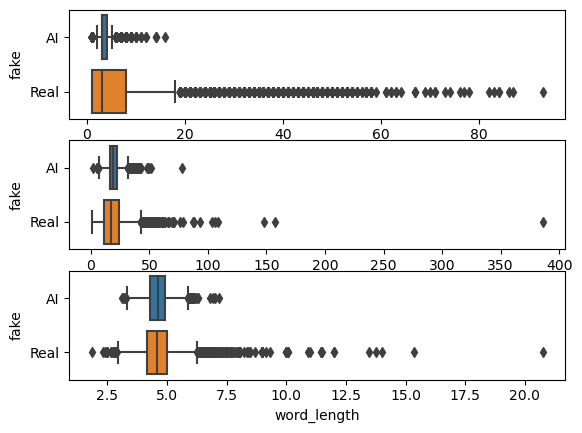

In [26]:
fig, ax = plt.subplots(nrows = 3, ncols = 1)

sns.boxplot(ax = ax[0], x = df['num_sentences'], y = df['fake'].map({0 : 'Real', 1 : 'AI'}))
sns.boxplot(ax = ax[1], x = df['sentence_length'], y = df['fake'].map({0 : 'Real', 1 : 'AI'}))
sns.boxplot(ax = ax[2], x = df['word_length'], y = df['fake'].map({0 : 'Real', 1 : 'AI'}));

It looks like there is a difference in spread but what's really striking here is that the AI responses are much more consistent. This is of course obvious in retrospect since computers are much more consistent than humans. It will be interesting to see if and how these variables affect our model.

In [27]:
np.mean(df[df['fake'] == 1]['response_cleaned'].apply(punc_counter)), np.mean(df[df['fake'] == 0]['response_cleaned'].apply(punc_counter)) # Real responses use MUCH more punctuation

(8.665065582856087, 35.476815074819875)

In [20]:
df['punc_count'] = df['response_cleaned'].apply(punc_counter)

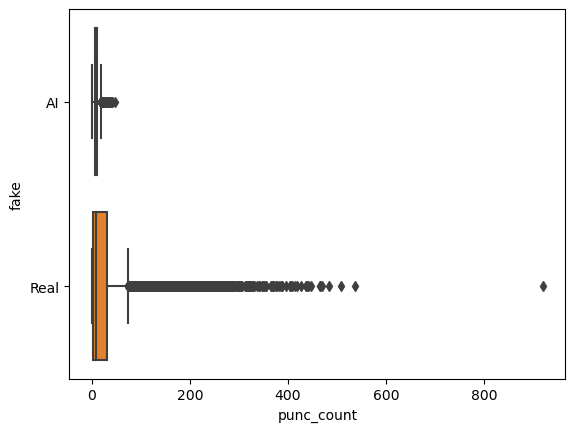

In [29]:
sns.boxplot(x = df['punc_count'], y = df['fake'].map({0 : 'Real', 1 : 'AI'}));

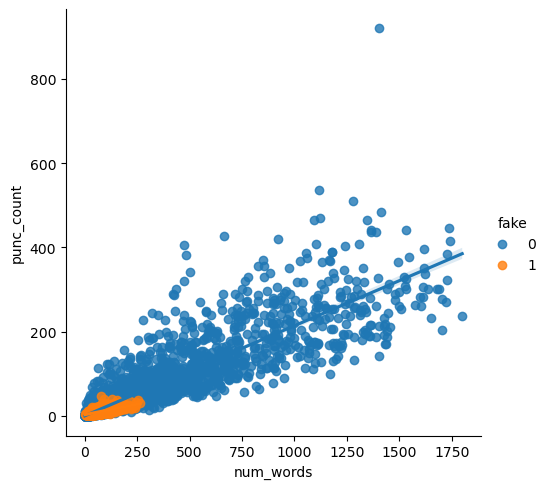

In [30]:
sns.lmplot(
    data = df,
    x = 'num_words',
    y = 'punc_count',
    hue = 'fake'
);

There is a correlation between number of words in a response and amount of punctuation (of course) and real and AI responses use punctuation at very different rates but this doesn't quite feel right so let's scale this punctuation variable by length of comment in words. The goal here is keep this as a relevant feature but reduce how correlated it is to length of response since we know that AI responses were only allowed to be so long.

In [21]:
df['punc_ratio'] = df['punc_count'] / df['num_words']

df.groupby('fake')['punc_ratio'].mean()

fake
0    0.202862
1    0.145967
Name: punc_ratio, dtype: float64

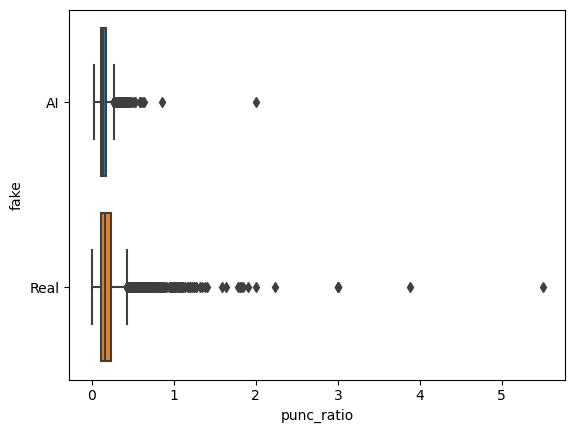

In [32]:
sns.boxplot(x = df['punc_ratio'], y = df['fake'].map({0 : 'Real', 1 : 'AI'}));

Once we account for the length of replies, this feature doesn't seem as important but we will still use it moving forward since it could be relevant in some of our ensemble models.

Let's take a look at how our model performances change with all this added information. The assumption is our accuracy will improve somewhat but some models like the Naive Bayes variants can behave a bit unpredictably when adding information that has varying ranges and scales.

In [22]:
X = df[['subreddit', 'response_cleaned', 'num_words', 'stop_words', 'num_sentences', 'sentence_length', 'word_length', 'punc_ratio']]
y = df['fake']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = rs, stratify = y)

meta_pipe = Pipeline(
    [
        ('ss', StandardScaler(with_mean = False)) # Since we're still testing with Naive Bayes we need to set this to false for now
    ]
)

text_pipe = Pipeline(
    [
        ('vect', CountVectorizer())
    ]
)

subreddit_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder())
    ]
)

col_trans = ColumnTransformer(
    [
        ('meta', meta_pipe, make_column_selector(dtype_include = np.number)),
        ('text', text_pipe, 'response_cleaned'),
        ('ohe', subreddit_pipe, ['subreddit'])
    ],
    n_jobs = -1
)


mnb_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('mnb', MultinomialNB())
    ]
)

bnb_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('bnb', BernoulliNB())
    ]
)

gnb_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('densify', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)),
        ('gnb', GaussianNB())
    ]
)

logr_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('logr', LogisticRegression(max_iter = 500, n_jobs = -1))
    ]
    )

rf_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('rf', RandomForestClassifier(random_state = rs, n_jobs = -1))
    ])

et_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('et', ExtraTreesClassifier(random_state = rs, n_jobs = -1))
    ]
)

linear_svc_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('lsvc', SVC(kernel = 'linear'))
    ]
)

rsvc_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('rsvc', SVC(kernel = 'rbf'))
    ]
)

adbc_pipe = Pipeline(
    [
        ('ct', col_trans),
        ('adbc', AdaBoostClassifier())
    ]
)

mnb_pipe.fit(X_train, y_train)
bnb_pipe.fit(X_train, y_train)
gnb_pipe.fit(X_train, y_train)
logr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
et_pipe.fit(X_train, y_train)
linear_svc_pipe.fit(X_train, y_train)
rsvc_pipe.fit(X_train, y_train)
adbc_pipe.fit(X_train, y_train)

print("MNB Train: {}\nMNB Test: {}\n----".format(mnb_pipe.score(X_train, y_train), mnb_pipe.score(X_test, y_test)))
print("BNB Train: {}\nBNB Test: {}\n----".format(bnb_pipe.score(X_train, y_train), bnb_pipe.score(X_test, y_test)))
print("GNB Train: {}\nGNB Test: {}\n----".format(gnb_pipe.score(X_train, y_train), gnb_pipe.score(X_test, y_test)))
print("LogReg Train: {}\nLogReg Test: {}\n----".format(logr_pipe.score(X_train, y_train), logr_pipe.score(X_test, y_test)))
print("RF Train: {}\nRF Test: {}\n----".format(rf_pipe.score(X_train, y_train), rf_pipe.score(X_test, y_test)))
print("ET Train: {}\nET Test: {}\n----".format(et_pipe.score(X_train, y_train), et_pipe.score(X_test, y_test)))
print("LSVC Train: {}\nLSVC Test: {}\n----".format(linear_svc_pipe.score(X_train, y_train), linear_svc_pipe.score(X_test, y_test)))
print("RSVC Train: {}\nRSVC Test: {}\n----".format(rsvc_pipe.score(X_train, y_train), rsvc_pipe.score(X_test, y_test)))
print("AdaBoost Train: {}\nAdaBoost Test: {}\n----".format(adbc_pipe.score(X_train, y_train), adbc_pipe.score(X_test, y_test)))

MNB Train: 0.7557580982879665
MNB Test: 0.690062800147765
----
BNB Train: 0.6962680133021308
BNB Test: 0.6738086442556336
----
GNB Train: 0.9051607340805518
GNB Test: 0.5755448836350203
----
LogReg Train: 0.9954427885207537
LogReg Test: 0.8902844477281123
----
RF Train: 1.0
RF Test: 0.8873291466568156
----
ET Train: 1.0
ET Test: 0.9043221278167713
----
LSVC Train: 0.9991378248552777
LSVC Test: 0.8673808644255634
----
RSVC Train: 0.9100874491932504
RSVC Test: 0.8862209087550794
----
AdaBoost Train: 0.8949378002217022
AdaBoost Test: 0.888806797192464
----


Using our finalized feature set and a count vectorizer we see that most of our models perform much better here than before which is to be expected since we added more features. Again we see Adaptive Boosting climbing the rankings and we also see Radial SVM regain its lead above the Linear kernel. The outlier here is Multinomial Naive Bayes, usurprisingly as we added more features that don't mesh well with the requirement of independent predictors and predictors that mostly come from the same type of distributions we see the performance drop. Moving forward the three models we'll be looking at and tuning are:
- Extra Trees
- Radial SVC
- Adaptive Boosting